In [2]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find

from run_id import run_id
run_id = 384
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)

wos_all_2000


In [3]:
doc_ids = list(set(Doc.objects.filter(doctopic__topic__run_id=run_id).values_list('id',flat=True)))
docs = Doc.objects.filter(id__in=doc_ids)

print(docs.count())

3495


In [4]:
abstracts, docsizes, ids = proc_docs(docs, stoplist)

tfidf_vectorizer = TfidfVectorizer(
        max_df=0.9,
        min_df=2,
        max_features=500000,
        ngram_range=(stat.ngram,stat.ngram),
        tokenizer=snowball_stemmer(),
        stop_words=stoplist
    )
tfidf = tfidf_vectorizer.fit_transform(abstracts)

In [5]:
print(tfidf.shape)

(3495, 8769)


In [6]:
tfidf_m = tfidf.toarray()
tfidf_m[tfidf_m==0.0]=np.nan

In [8]:
tfidf_m.shape

(3495, 8769)

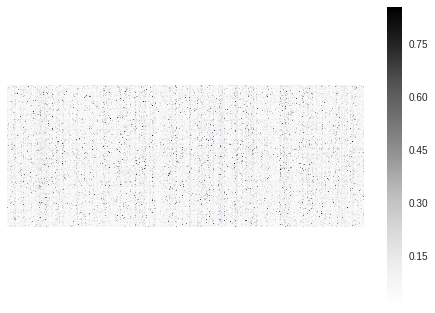

In [6]:
import seaborn as sns; sns.set()

ax = sns.heatmap(tfidf_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True)

plt.show()

In [7]:
nmf = NMF(n_components=50, random_state=1,
              alpha=stat.alpha, l1_ratio=.1, verbose=False,
              init='nndsvd', max_iter=stat.max_iterations).fit(tfidf)

81226


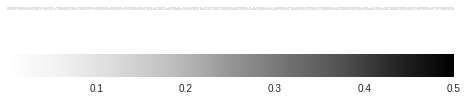

(50, 8769)


In [8]:
W = coo_matrix(nmf.components_)

print(len(find(W)[0]))

W_m = W.toarray()
W_m[W_m>0.5]=0.5
W_m[(W_m<0.3) & (W_m>0.0005)]=0.1
W_m[W_m==0.0]=np.nan


ax = sns.heatmap(W_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
                 cbar_kws={'orientation': 'horizontal'})

plt.savefig('../plots/W.png',bbox_inches='tight')
plt.show()

print(W.shape)



In [13]:
H = coo_matrix(nmf.transform(tfidf))

H_m = H.toarray()
H_m[(H_m<0.3) & (H_m>0.0005)]=0.1
H_m[H_m==0.0]=np.nan



ax = sns.heatmap(
    H_m,
    xticklabels=False,
    yticklabels=False,
    cmap="Greys",
    square=True,
    cbar_ax=None
)

plt.savefig('../plots/H.png',bbox_inches='tight')

plt.show()

print(H.shape)

ValueError: Image size of 4040910x1384118 pixels is too large. It must be less than 2^16 in each direction.

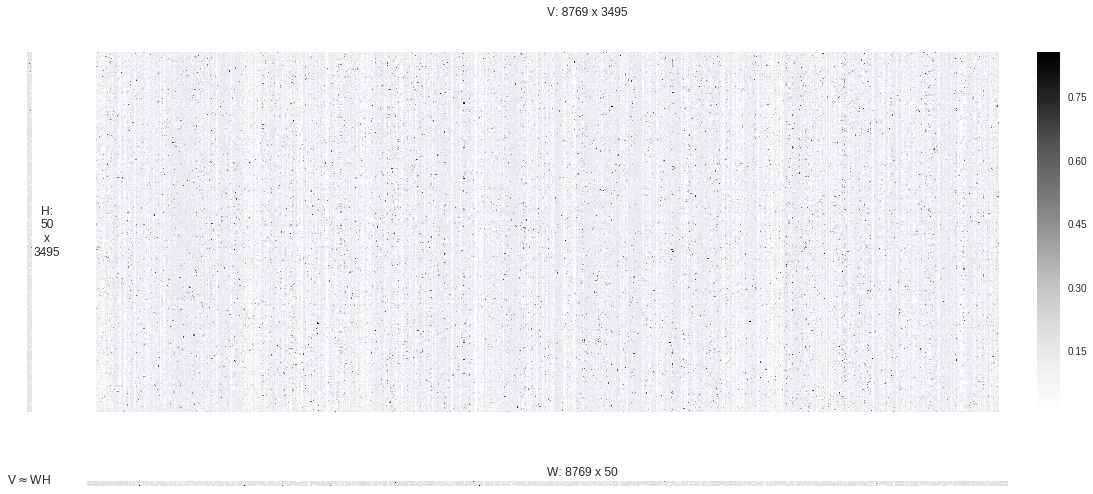

In [10]:
plt.rcParams["figure.figsize"] = [16,10]

fig = plt.figure()


###
ax1 = fig.add_axes([-0.45,0.5  ,0.8  ,0.5])
ax2 = fig.add_axes([0    ,0.15 ,0.8  ,0.5])
ax3 = fig.add_axes([0    ,0.5  ,0.8  ,0.5])
ax4 = fig.add_axes([0.825,0.5  ,0.02 ,0.5])

tfidf_m = tfidf.toarray()
tfidf_m[tfidf_m==0.0]=np.nan

sns.heatmap(
    H_m,
    xticklabels=False,
    yticklabels=False,
    cmap="Greys",
    square=True,
    ax=ax1,
    cbar=False
)

sns.heatmap(
    W_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
    ax=ax2,
    #cbar_ax=ax4
    cbar=False
)

sns.heatmap(
    tfidf_m,
    xticklabels=False,
    yticklabels=False,
    cmap="Greys",
    square=True,
    ax=ax3,
    cbar_ax=ax4
)

m = tfidf_m.shape[0] # docs
n = tfidf_m.shape[1] # terms
r = H_m.shape[1] # topics

ax1.text(H_m.shape[1]*4,H_m.shape[0]/2,"H:\n{}\nx\n{}".format(H_m.shape[1],H_m.shape[0]),
        va="center", ha="center")

ax1.text(H_m.shape[1]/2,-H_m.shape[0]/5,r'V$\approx$WH',ha="center")
ax2.text(W_m.shape[1]/2,W_m.shape[0]*2,"W: {} x {}".format(W_m.shape[1],W_m.shape[0]))
ax3.text(n*0.5,m*1.1,"V: {} x {}".format(n,m))

#fig.tight_layout()
plt.savefig('../plots/VWH.png',bbox_inches='tight')

plt.show()

In [11]:
plt.rcParams["figure.figsize"] = [16,10]

fig = plt.figure()


###
ax1 = fig.add_axes([-0.45,0.5  ,0.8  ,0.5])
ax2 = fig.add_axes([0    ,0.15 ,0.8  ,0.5])
ax3 = fig.add_axes([0    ,0.5  ,0.8  ,0.5])
ax4 = fig.add_axes([0.825,0.5  ,0.02 ,0.5])

tfidf_m = tfidf.toarray()
tfidf_m[tfidf_m==0.0]=np.nan

H_m_blank = H_m


W_m_blank = W_m


sns.heatmap(
    H_m_blank,
    xticklabels=False,
    yticklabels=False,
    cmap="Greys",
    square=True,
    ax=ax1,
    cbar=False
)

sns.heatmap(
    W_m_blank,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
    ax=ax2,
    #cbar_ax=ax4
    cbar=False
)



m = tfidf_m.shape[0] # docs
n = tfidf_m.shape[1] # terms
r = H_m.shape[1] # topics

ax3.text(n*0.5,m*1.1,"V: {} x {}".format(n,m))

#fig.tight_layout()
plt.savefig('../plots/V_blank_WH.png',bbox_inches='tight')

plt.show()

ValueError: Image size of 4040910x1384118 pixels is too large. It must be less than 2^16 in each direction.

In [ ]:


fig = plt.figure()

#ax1 = fig.add_axes([-0.4,0.5,0.8,0.8])
#ax2 = fig.add_axes([0.05,0.2,0.8,0.8])
#ax3 = fig.add_axes([0.05,0.5,0.8,0.8])
#ax4 = fig.add_axes([0.8,0.5,0.02,0.8])


###
ax1 = fig.add_axes([-0.45,0.5  ,0.8  ,0.5])
ax2 = fig.add_axes([0    ,0.15 ,0.8  ,0.5])
ax3 = fig.add_axes([0    ,0.5  ,0.8  ,0.5])
ax4 = fig.add_axes([0.825,0.5  ,0.02 ,0.5])


tfidf_m = tfidf.toarray()

sns.heatmap(
    H_m,
    xticklabels=False,
    yticklabels=False,
    cmap="Greys",
    square=True,
    ax=ax1,
    cbar=False
)

sns.heatmap(
    W_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
    ax=ax2,
    cbar=False
)



sns.heatmap(
    W_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
    ax=ax3,
    #cbar=False,
    cbar_ax=ax4
)

m = tfidf_m.shape[0] # docs
n = tfidf_m.shape[1] # terms
r = H_m.shape[1] # topics

ax1.text(H_m.shape[1]*5,H_m.shape[0]/2,"H:\n{}\nx\n{}".format(H_m.shape[1],H_m.shape[0]),
        va="center", ha="center")

ax1.text(H_m.shape[1]/2,-H_m.shape[0]/5,r'V$\approx$WH',ha="center")
ax2.text(W_m.shape[1]/2,W_m.shape[0]*2,"W: {} x {}".format(W_m.shape[1],W_m.shape[0]))
ax3.text(n*0.5,m*1.1,"V: {} x {}".format(n,m))

#plt.bar(0,1,ax=ax3)

#p = vvrect(X_count[x], crange[x] ,a)


plt.show()

In [ ]:
W_m_blank